In [1]:
!jt -r

Reset css and font defaults in:
C:\Users\anoni\.jupyter\custom &
C:\Users\anoni\AppData\Roaming\jupyter\nbextensions


# Установка библиотек

In [479]:
!pip install -U scikit-learn

Установка **scikit-learn**

Библиотека для обучения и тестирование модели

In [3]:
!pip install pandas

Установка **pandas**

Библиотека для чтения и обработки данных

In [4]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


Установка **langdetect**

Библиотека для определения основного языка текста

In [5]:
!pip install nltk

Установка **nltk**

Библиотека для удаления стоп-слов из текста

In [6]:
!pip install matplotlib

Установка **matplotlib**

Библиотека для визуализации данных

In [7]:
!pip install plotly

# Импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import pickle
import warnings

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from langdetect import detect
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import learning_curve

# Описание импортов

```Python
import pandas as pd
```
- Библиотека для чтения и записи данных
___
```Python
import matplotlib.pyplot as plt
``` 
- Библиотека для визуализации данных
___
```Python
import nltk
``` 
- Библиотека для обработки текста
___
```Python
import string
```
- Библиотека, содержащая всю пунктуацию
___
```Python
import pickle
```
- Библиотека для сохранения модели
___
```Python
import warnings
```
- Библиотека, отключающая предупреждения pandas
___
```Python
from collections import Counter
``` 
- Функция для подсчёта повторов слов в данных
___
```Python
from nltk.corpus import stopwords
``` 
- Список стоп-слов
___
```Python
from nltk.tokenize import word_tokenize
``` 
- Функция для токиницирования строки
___
```Python
from nltk.stem import SnowballStemmer
``` 
- Функция для обработки слов
___
```Python
from langdetect import detect
```
- Библиотека для определения основного языка текста
___
```Python
from tqdm import tqdm
```
- Библиотека для визуализации прогресс бара
___
```Python
from sklearn.model_selection import train_test_split
```
- Библиотека для разделения на тренировочную и тестовую выборку
___
```Python
from sklearn.feature_extraction.text import TfidfVectorizer
```
- Функция для векторизации предложения
___
```Python
from sklearn.linear_model import LogisticRegression
```
- Модель
___
```Python
from sklearn.metrics import classification_report
```
- Метрика
___
```Python
from sklearn.metrics import plot_roc_curve
```
- Функция для построения графиков
___
```Python
from sklearn.metrics import plot_precision_recall_curve
```
- функция для построения графиков
___
```Python
from sklearn.model_selection import learning_curve
```
- Функция для построения кривой обучения

## Отключение предупреждений

In [2]:
warnings.filterwarnings("ignore")

# Первичная обработка 

In [3]:
data = pd.read_csv("labeled.csv")

Загрузка данных с токсичными сообщениями

In [4]:
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\r\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\r\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [5]:
data.dtypes

comment     object
toxic      float64
dtype: object

In [6]:
data.toxic = data.toxic.apply(int)

In [7]:
data.size

28824

In [8]:
data = data.drop_duplicates()

Удаления дубликатов для обучения

## Проверка на null значения

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  14412 non-null  object
 1   toxic    14412 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 337.8+ KB


## Визуализация отношения токсичных сообщений к обычным

Text(0.5, 1.0, 'Отношение сообщений')

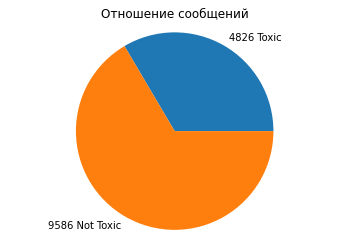

In [10]:
labels = [f"{len(data.loc[data.toxic == 1])}" + " Toxic", f"{len(data.loc[data.toxic == 0])}" + " Not Toxic"]
fig, ax = plt.subplots()
ax.pie([len(data.loc[data.toxic == 1]), len(data.loc[data.toxic == 0])], labels=labels)
ax.axis("equal")
plt.title("Отношение сообщений")

Круговая диаграмма отношения

Из данной диаграммы можно сделать вывод, что токсичных сообщений _меньше_, чем обычных, следовательно, точность определения токсичных сообщений может снизиться

# Финальная обработка данных

## Первичная обработка текста

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anoni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Загрузка stopwords

_Слова по типу "ну", "же" и тд._

In [12]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

In [13]:
def tokinize_sentence(sentence: str):
    sentence = sentence.strip().lower()
    try:
        if detect(sentence) == "ru":
            sentence.replace("e", "е").replace("a", "а").replace("c", "с").replace("p", "р").replace("o", "о").replace("M", "м").replace("H", "н").replace("B", "в")
            sentence.replace("не ", "не").replace("no ", "no")
    except:
        pass
    sentence.replace("\t", " ")
    for i in string.punctuation:
        if i in sentence and i != " ":
            sentence = sentence.replace(i, '')
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return " ".join(tokens)

### Описание функции
___
```Python
sentence = sentence.strip().lower()
```
- Удаление "\n" из текста, приведение к нижнему регистру
___
```Python
if detect(sentence) == "ru":
```
- Проверка на основной язык текста
___
```Python
sentence.replace("e", "е").replace("a", "а").replace("c", "с")...
```
- Замена английских букв на схожие русские _(Если основной язык русский)_
___
```Python
for i in string.punctuation:
        if i in sentence and i != " ":
            sentence = sentence.replace(i, '')
```
- Удаление пунктуации из текста
___
```Python
tokens = word_tokenize(sentence, language="russian")
```
- Токенизация предложений
___
```Python
tokens = [i for i in tokens if i not in russian_stop_words]
```
- Удаление стоп слов из текста
___
```Python
tokens = [snowball.stem(i) for i in tokens]
```
- Удаление окончаний
___
```Python
return " ".join(tokens)
```
- Возврат преобразованного текста

In [14]:
tqdm.pandas()

data_token = data.copy()
data_token.comment = data_token.comment.progress_apply(tokinize_sentence)
data_token.head()

100%|███████████████████████████████████████████████████████████████████████████| 14412/14412 [01:02<00:00, 231.14it/s]


,comment,toxic
0,верблюдовт дебил бл,1
1,хохл эт отдушин затюкан россиянин мол вон хохл...,1
2,собак собач смерт,1
3,страниц обнов деб эт оскорблен доказа факт нед...,1
4,убед 6страничн пдф скрипал отрав росс анализир...,1


Обработка данных для дальнейшего обучения
___
_Убераем окончания, приводим слова в нижний регистр_

## Удаление дубликатов и пустых значений

### Поиск и удаление пустых значений

In [15]:
data = data_token.copy()
empty = data[data.comment == '']
print('Количество пустых значений: ', len(empty))
data = data.drop(empty.index)

Количество пустых значений:  1


### Поиск дубликатов

In [16]:
print('Дубликаты: ', data.duplicated().sum())

Дубликаты:  222


### Удаление дубликатов

In [17]:
data = data.drop_duplicates()

Первичное удаление дубликатов

In [18]:
comment_duplicated = data[data.comment.duplicated('last')]
comment_duplicated.head()

,comment,toxic
127,ночн большевистск обострен,1
158,эт сво мам сестр родн утр,1
358,писечк поперек эт мам переда,1
540,прост социальн несправедлив дает поко предыдущ...,0
660,осторожн увид пишет переебет ног,1


Вывод дубликатов

In [19]:
data = data.drop_duplicates(subset='comment')

Удаление дубликатов по столбцу comment

# Визуализация самых популярных слов

### Текстовая визуализация

In [20]:
sorted_counter = Counter(' '.join(data.comment.values).split()).most_common()
sorted_counter[:5]

[('эт', 4405), ('так', 1550), ('котор', 1386), ('прост', 1176), ('сво', 954)]

### График самых частоупотребляемых слов

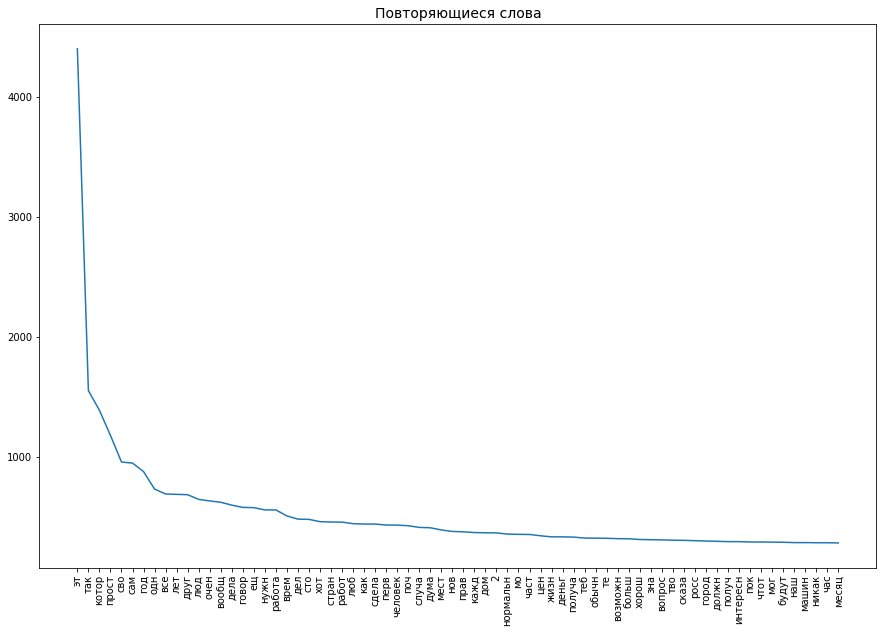

In [21]:
plt.figure(figsize=(15, 10))
plt.plot([i[0] for i in sorted_counter][:70], [i[1] for i in sorted_counter][:70])
plt.xticks(rotation=90)
plt.title('Повторяющиеся слова', fontsize=14)
plt.show()

### График длинны текста для токсичных сообщений

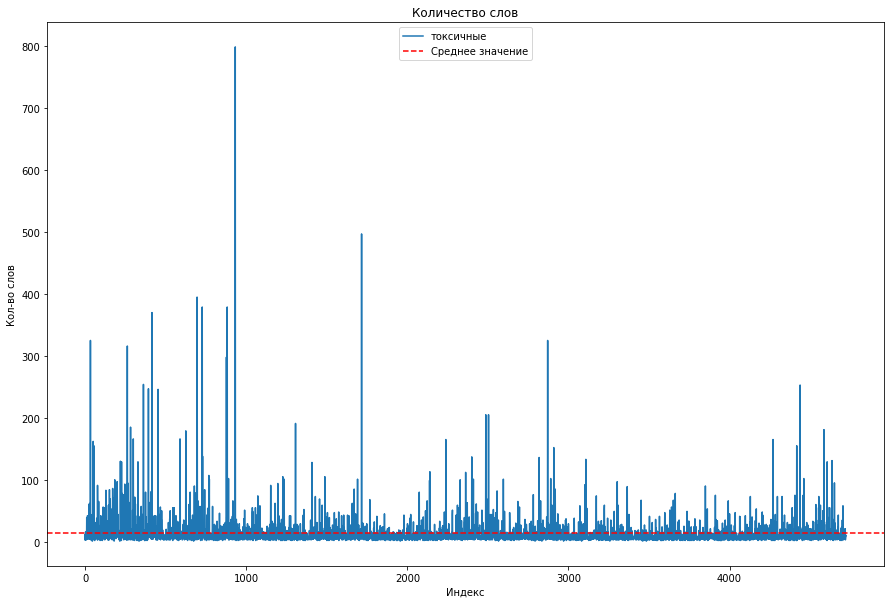

In [22]:
plt.figure(figsize=(15, 10))
plt.plot([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]], label="токсичные")
plt.xlabel("Индекс")
plt.ylabel("Кол-во слов")
plt.title("Количество слов")
plt.axhline(pd.DataFrame([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]]).mean()[0], linestyle="dashed", label="Среднее значение", c="r")
plt.legend(loc=9)
plt.show()

### График длинны текста для обычных сообщений

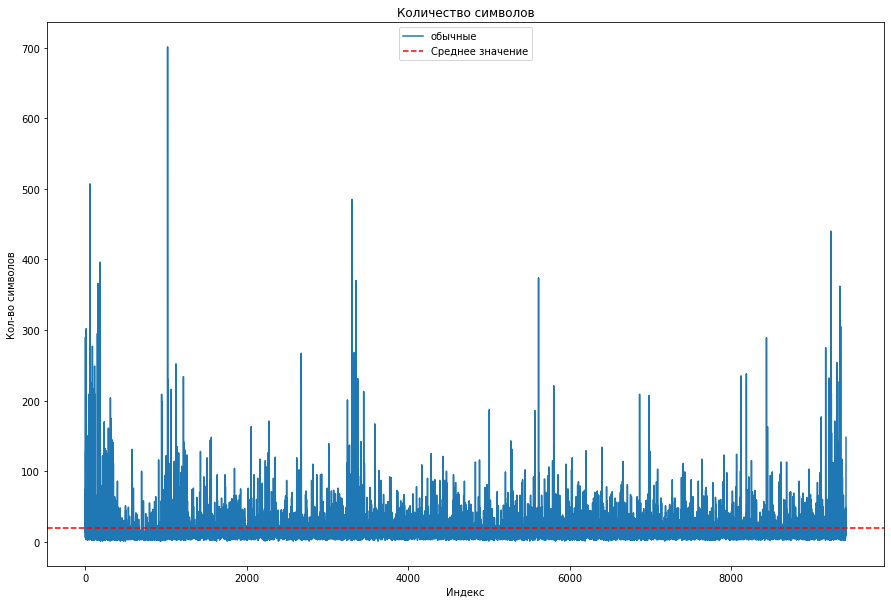

In [23]:
plt.figure(figsize=(15, 10))
plt.plot([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]], label="обычные")
plt.xlabel("Индекс")
plt.ylabel("Кол-во символов")
plt.title("Количество символов")
plt.axhline(pd.DataFrame([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]]).mean()[0], linestyle="dashed", label="Среднее значение", c="r")
plt.legend(loc=9)
plt.show()

### График длинны текста для токсичных сообщений наложенный на обычные

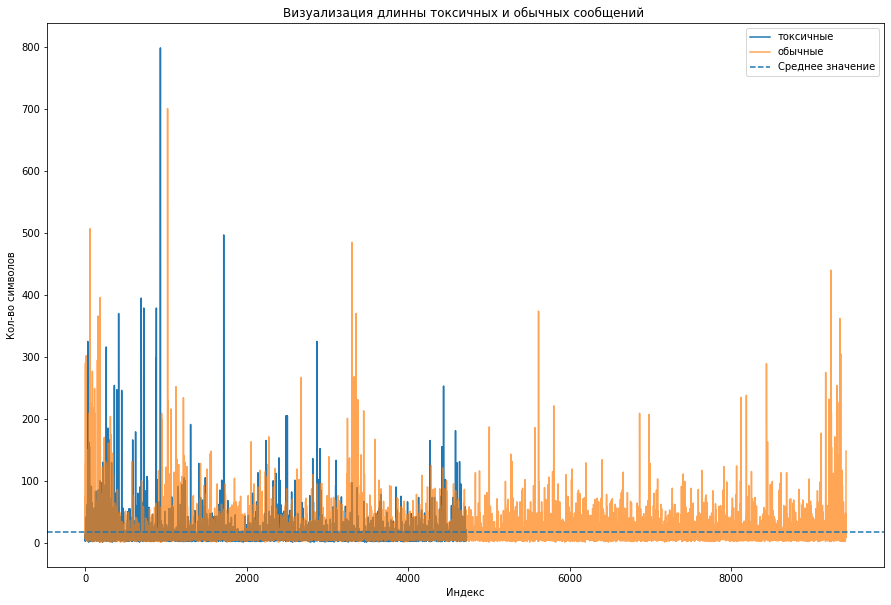

In [24]:
plt.figure(figsize=(15, 10))
plt.plot([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]], label="токсичные")
plt.plot([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]], alpha=0.7, label="обычные")
plt.xlabel("Индекс")
plt.ylabel("Кол-во символов")
plt.title("Визуализация длинны токсичных и обычных сообщений ")
plt.axhline(pd.DataFrame([len(i.split()) for i in data["comment"]]).mean()[0], linestyle="dashed", label="Среднее значение")
plt.legend(loc=1)
plt.show()

### Отношение количества обычных комментариев к токсичным

Text(0.5, 1.0, 'Отношение сообщений')

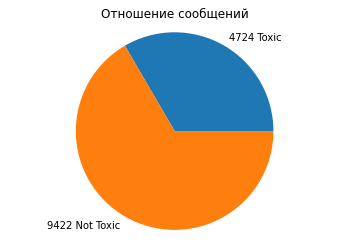

In [25]:
labels = [f"{len(data.loc[data.toxic == 1])}" + " Toxic", f"{len(data.loc[data.toxic == 0])}" + " Not Toxic"]
fig, ax = plt.subplots()
ax.pie([len(data.loc[data.toxic == 1]), len(data.loc[data.toxic == 0])], labels=labels)
ax.axis("equal")
plt.title("Отношение сообщений")

Исходя из данных предыдущей диаграммы можем сделать вывод, что при удалении дубликатов, были удалены **164** обычных комментария и **102** токсичных


### Визуализация уменьшения длины сообщений

Text(0.5, 1.0, 'Визуализация начиная с самых длинных сообщений')

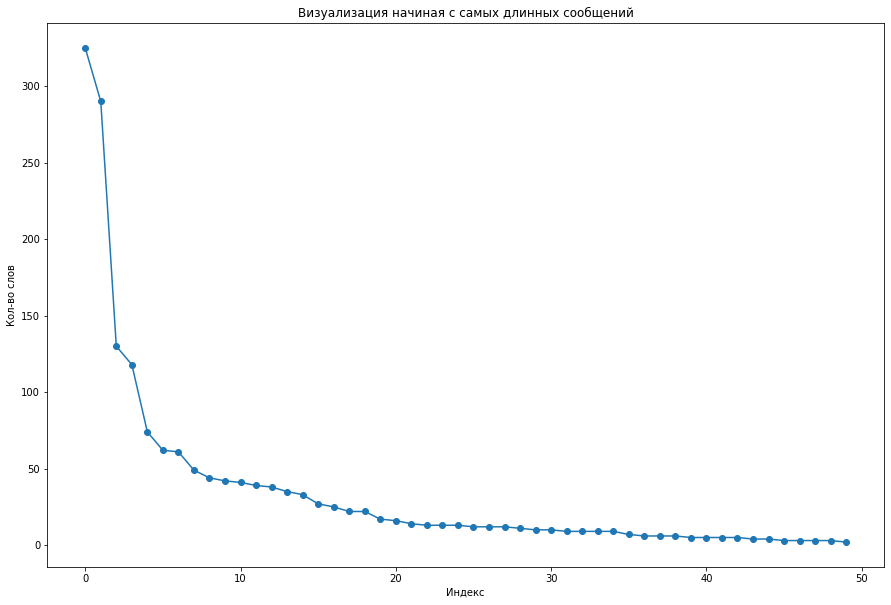

In [26]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data["comment"][:50]], reverse=True), marker="o")
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых длинных сообщений")

### Визуализация увеличенния длины сообщений

Text(0.5, 1.0, 'Визуализация начиная с самых коротких сообщений')

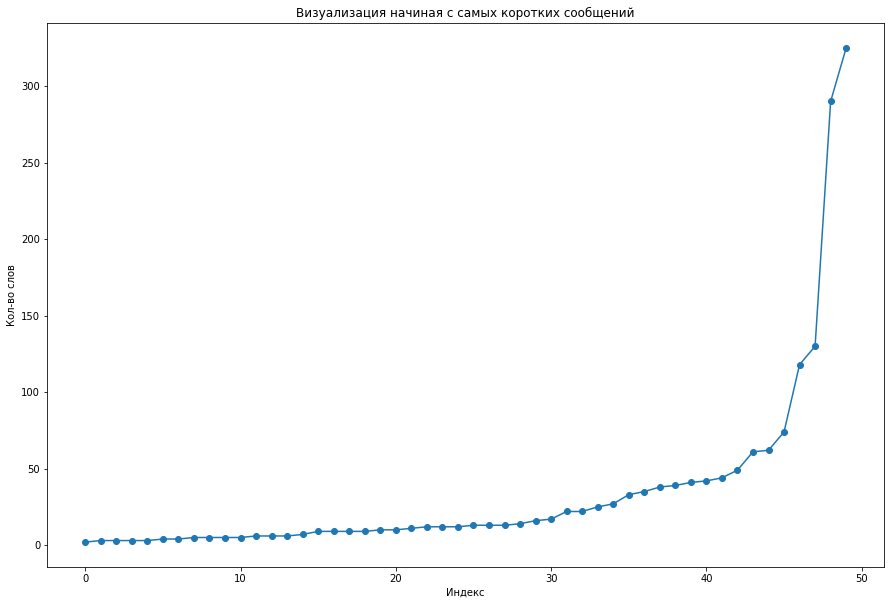

In [27]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data["comment"][:50]]), marker="o")
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых коротких сообщений")

### Пересечение графика увеличения и уменьшения длины

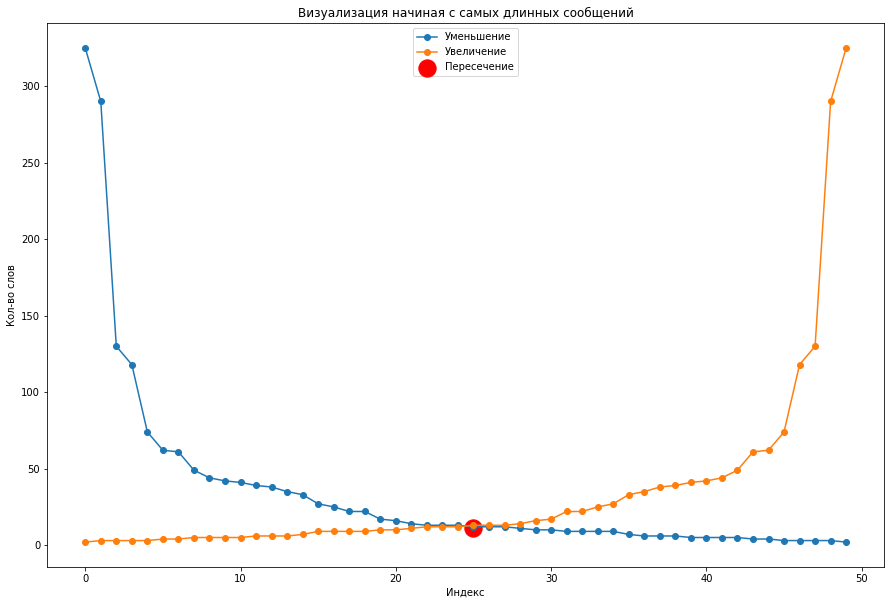

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data["comment"][:50]], reverse=True), marker="o", label="Уменьшение")
plt.plot(sorted([len(i.split()) for i in data["comment"][:50]]), marker="o", label="Увеличение")
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых длинных сообщений")
plt.scatter(25, 11, c = 'red', s=300, label="Пересечение")
plt.legend(loc=9)

### Вывод средней длины сообщений

In [29]:
print("Среднее кол-во слов:", pd.DataFrame([len(i.split()) for i in data["comment"]]).mean()[0])
print("Среднее кол-во слов токсичных сообщений:", pd.DataFrame([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]]).mean()[0])
print("Среднее кол-во слов обычных сообщений:", pd.DataFrame([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]]).mean()[0])

Среднее кол-во слов: 17.296762335642583
Среднее кол-во слов токсичных сообщений: 14.022650296359018
Среднее кол-во слов обычных сообщений: 18.938335809806834


### Визуализация графиков длины сообщений (всех, токсичных и обычных) 

Text(0.5, 1.0, 'Визуализация начиная с самых длинных сообщений')

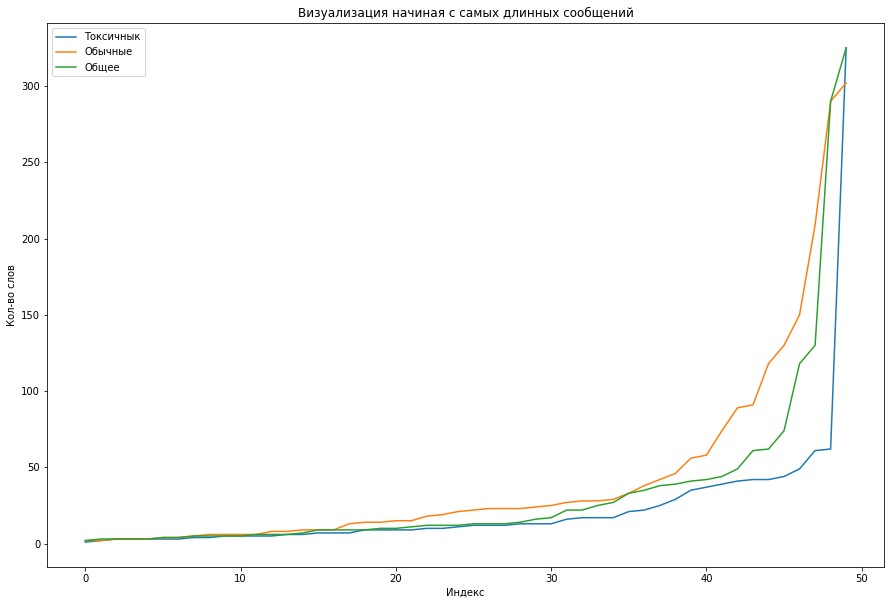

In [30]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]][:50]), label="Токсичнык")
plt.plot(sorted([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]][:50]), label="Обычные")
plt.plot(sorted([len(i.split()) for i in data["comment"]][:50]), label="Общее")
plt.legend(loc=2)
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых длинных сообщений")

### Визуализация графиков длины сообщений на более маленьком промежутке (всех, токсичных и обычных) 

Text(0.5, 1.0, 'Визуализация начиная с самых длинных сообщений')

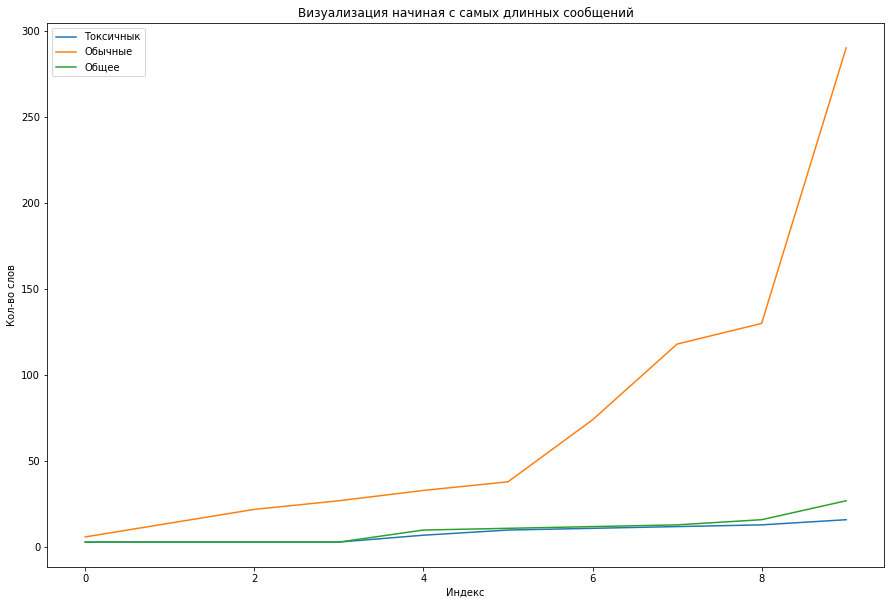

In [31]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]][:10]), label="Токсичнык")
plt.plot(sorted([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]][:10]), label="Обычные")
plt.plot(sorted([len(i.split()) for i in data["comment"]][:10]), label="Общее")
plt.legend(loc=2)
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых длинных сообщений")

# Разделение данных на тренировочную и тестовую выборки, создание фич

## Разделение на тренировочную и тестовую выборки

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data["comment"], data["toxic"], test_size=0.20, random_state=311)

## Создание фичей

In [33]:
vectorizer = TfidfVectorizer(ngram_range=(2,4), analyzer='char_wb', max_df=0.8, min_df=10)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print('Фичи: ', len(vectorizer.get_feature_names()))

Фичи:  16407


Создание фичей для обучения

In [34]:
with open("RussianVectorizer.bf", "+wb") as file:
    pickle.dump(vectorizer, file)

Сохранение векторизатора

# Обучение модели

## Создание и обучение модели

In [35]:
model = LogisticRegression(max_iter=10000, C=3, solver='liblinear')

Создание модели для обучения

In [36]:
model.fit(X_train, y_train)

LogisticRegression(C=3, max_iter=10000, solver='liblinear')

обучение модели

### Предсказание целевой переменной на тестовых данных

In [37]:
y_pred = model.predict(X_test)

Создание предсказаний

## Проверка score

### Вывод основных метрик

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1936
           1       0.88      0.79      0.83       894

    accuracy                           0.90      2830
   macro avg       0.89      0.87      0.88      2830
weighted avg       0.90      0.90      0.90      2830



Визуализация точности предсказаний

## Визуализация предсказаний

### Визуализация предсказаний тестовых данных

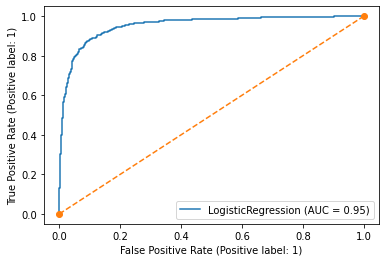

In [39]:
plot_roc_curve(model, X_test, y_test)
plt.plot([0, 1], [0, 1],'o--')
plt.show()

### Визуализация предсказаний тренировочных данных данных

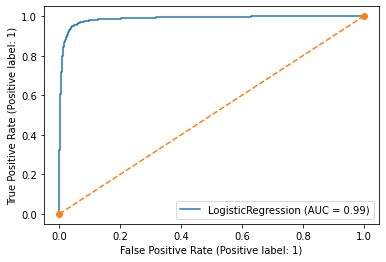

In [40]:
plot_roc_curve(model, X_train, y_train)
plt.plot([0, 1], [0, 1],'o--')
plt.show()

### Визуализация модели

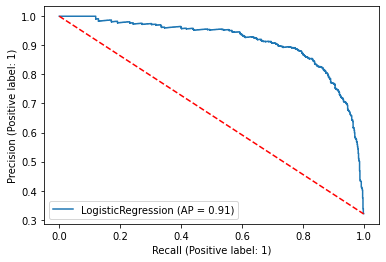

In [41]:
plot_precision_recall_curve(estimator=model, X=X_test, y=y_test)
plt.plot([0, 1], [1, 0.32],'r--')
plt.show()

In [42]:
train_sizes, train_scores, valid_scores = learning_curve(LogisticRegression(), X_train, y_train, train_sizes=[0.001, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9], cv=5)

Text(0, 0.5, 'y')

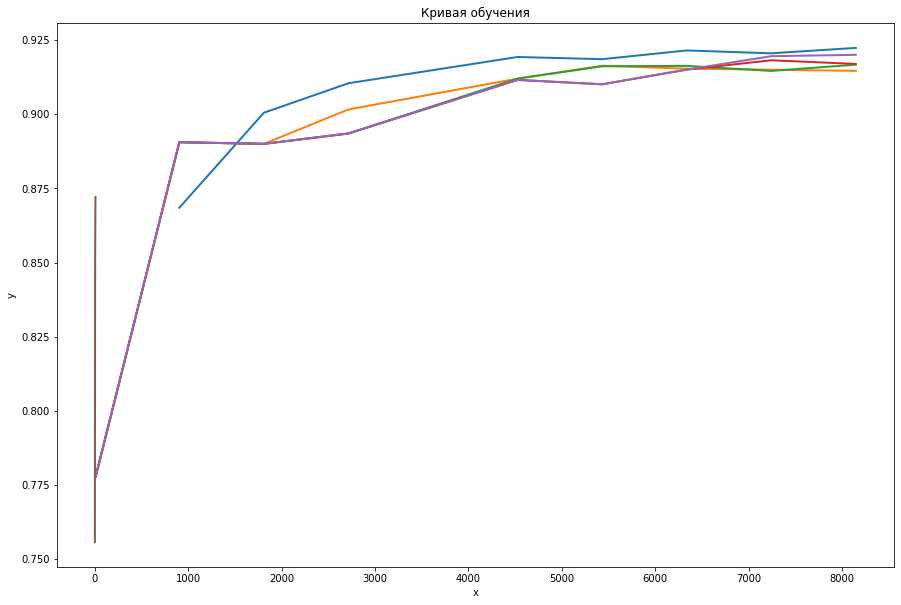

In [43]:
plt.figure(figsize=(15, 10))
plt.plot(train_sizes, train_scores, valid_scores.mean(axis=1), lw=2,
         label='cross-validation')
plt.title('Кривая обучения')
plt.xlabel('x')
plt.ylabel('y')

Кривая обучения позволяет узнать оптимальное количество данных для обучения

# Тест и сохраниение модели

## Тестирование модели

In [44]:
toxic_propabality = model.predict_proba(vectorizer.transform([tokinize_sentence("антон петлин")]))[0, 1]
print(f'Probability of toxicity: {toxic_propabality:.3f}')

Probability of toxicity: 0.306


```Python
toxic_propabality = model.predict_proba(vectorizer.transform([tokinize_sentence("а")]))[0, 1]
```
Определение токсичности сообщения
```Python
Probability of toxicity: 0.336
```
Вероятность того, что сообщение токсичное

## Сохраниение модели

In [45]:
with open("RussianModel.bf", "+wb") as file:
    pickle.dump(model, file)

Сохранение модели